In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import seaborn as sns
sns.set(style='whitegrid', palette='muted')

import json
import re
from glob import glob
import msgpack
import pickle
from sktime.performance_metrics.forecasting import mean_squared_scaled_error

In [49]:
loss_paths = sorted(glob("result/10-13-extended/experiment_*/analysis/loss.csv"))
server_config_paths = sorted(glob("result/10-13-extended/experiment_*/server_config.json"))
system_metrics_paths = sorted(glob("result/10-13-extended/experiment_*/analysis/system_df.csv"))
predictions_paths = sorted(glob("result/10-13-extended/experiment_*/analysis/predictions.csv"))


# loss_paths = sorted(glob("result/online_1_slide_friday_336_12_15_18_fits//experiment_*/analysis/loss.csv"))
# server_config_paths = sorted(glob("result/online_1_slide_friday_336_12_15_18_fits/experiment_*/server_config.json"))
# system_metrics_paths = sorted(glob("result/online_1_slide_friday_336_12_15_18_fits/experiment_*/analysis/system_df.csv"))
# predictions_paths = sorted(glob("result/online_1_slide_friday_336_12_15_18_fits/experiment_*/analysis/predictions.csv"))

In [50]:
result = []
for conf_path, loss_path, system_metrics_path, predictions_path in zip(
    server_config_paths, loss_paths, system_metrics_paths, predictions_paths
):
    conf = json.load(open(conf_path))
    loss_df = pd.read_csv(loss_path)
    system_df = pd.read_csv(system_metrics_path)
    prediction_df = pd.read_csv(predictions_path)

    if conf["use_per_key_slide_size_plan"]:
        slide_side = re.match(".*plan_(.*).json", conf["per_key_slide_size_plan_path"]).group(1)
    else:
        slide_side = conf["global_slide_size"]

    
    max_cpu = int(system_df.groupby("time")["cpu"].sum().mean())
    total_loss = loss_df["loss"].dropna().sum()
    log_loss = np.log10(loss_df["loss"].dropna().sum())
    num_missing_keys = loss_df["loss"].isna().sum()
    total_predictions = len(prediction_df)

    result.append(
        {
            "slide_size": slide_side,
            "total_loss": total_loss,
            "mapper_replicas": conf["map_num_replicas"],
            "cpu": max_cpu,
            "num_mapper": conf["map_num_replicas"],
            "num_missing_keys": num_missing_keys,
            "total_predictions": total_predictions,
            "log10_loss": log_loss,
            "loss_path": loss_path,
            "predictions_path": predictions_path,
        }
    )
    
result_df = pd.DataFrame(result)
# result_df = result_df[result_df.total_predictions > 10000]

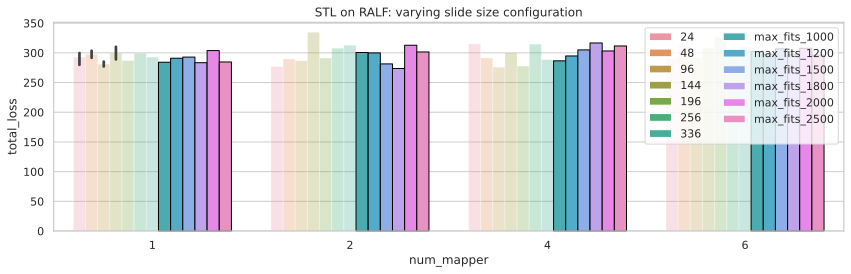

In [51]:
plt.figure(figsize=(12,4))

slide_sizes = result_df[result_df.slide_size.str.contains("max_fits").isna()]
costs = result_df[~result_df.slide_size.str.contains("max_fits").isna()]

hues = result_df.slide_size.unique().tolist()
slide_size_hues = list(sorted([x for x in hues if type(x) is int]))
cost_hues = list(sorted([x for x in hues if type(x) is str]))

hue_order = slide_size_hues + cost_hues

ax = sns.barplot(data=result_df, hue="slide_size", y="total_loss", x="num_mapper", hue_order=hue_order)
plt.tight_layout()
plt.title("STL on RALF: varying slide size configuration")
plt.legend(ncol=2)
for i in range(28):
    ax.patches[i].set_alpha(0.3)
for i in range(28, 28 + 24):
    # ax.patches[i].set_hatch("/")
    ax.patches[i].set_edgecolor("black")

In [52]:
result_df

,slide_size,total_loss,mapper_replicas,cpu,num_mapper,num_missing_keys,total_predictions,log10_loss,loss_path,predictions_path
0,24,299.125407,1,7,1,0,64400,2.475853,result/10-13-extended/experiment_1634112297/an...,result/10-13-extended/experiment_1634112297/an...
1,24,299.638589,1,14,1,0,64400,2.476598,result/10-13-extended/experiment_1634113101/an...,result/10-13-extended/experiment_1634113101/an...
2,48,303.626217,1,12,1,0,64400,2.482339,result/10-13-extended/experiment_1634113905/an...,result/10-13-extended/experiment_1634113905/an...
3,96,277.081937,1,15,1,0,64400,2.442608,result/10-13-extended/experiment_1634114709/an...,result/10-13-extended/experiment_1634114709/an...
4,144,310.241212,1,11,1,0,64400,2.491699,result/10-13-extended/experiment_1634115514/an...,result/10-13-extended/experiment_1634115514/an...
5,196,287.055665,1,9,1,0,64400,2.457966,result/10-13-extended/experiment_1634116318/an...,result/10-13-extended/experiment_1634116318/an...
6,256,299.461087,1,10,1,0,64400,2.476340,result/10-13-extended/experiment_1634117122/an...,result/10-13-extended/experiment_1634117122/an...
7,336,292.920911,1,10,1,0,64400,2.466750,result/10-13-extended/experiment_1634117926/an...,result/10-13-extended/experiment_1634117926/an...
8,max_fits_1000,284.254993,1,11,1,0,64400,2.453708,result/10-13-extended/experiment_1634118730/an...,result/10-13-extended/experiment_1634118730/an...
9,max_fits_1200,290.988583,1,11,1,0,64400,2.463876,result/10-13-extended/experiment_1634119534/an...,result/10-13-extended/experiment_1634119534/an...


<AxesSubplot:title={'center':'Impact of Slide Size on Loss for 4 Parallel Trainers'}, xlabel='slide_size', ylabel='total_loss'>

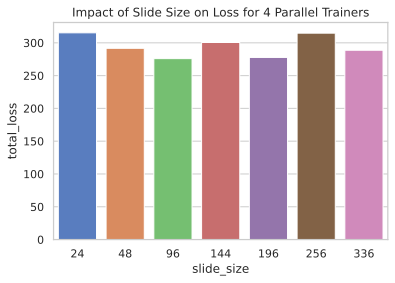

In [53]:
num_mapper = 4
plt.title(f"Impact of Slide Size on Loss for {num_mapper} Parallel Trainers")

mapper_4_slide_size = slide_sizes[slide_sizes.num_mapper == num_mapper]
sns.barplot(data=mapper_4_slide_size, x="slide_size", y="total_loss")

In [54]:
result_df.slide_size.unique()

array([24, 48, 96, 144, 196, 256, 336, 'max_fits_1000', 'max_fits_1200',
       'max_fits_1500', 'max_fits_1800', 'max_fits_2000', 'max_fits_2500'],
      dtype=object)

In [55]:
result_df

,slide_size,total_loss,mapper_replicas,cpu,num_mapper,num_missing_keys,total_predictions,log10_loss,loss_path,predictions_path
0,24,299.125407,1,7,1,0,64400,2.475853,result/10-13-extended/experiment_1634112297/an...,result/10-13-extended/experiment_1634112297/an...
1,24,299.638589,1,14,1,0,64400,2.476598,result/10-13-extended/experiment_1634113101/an...,result/10-13-extended/experiment_1634113101/an...
2,48,303.626217,1,12,1,0,64400,2.482339,result/10-13-extended/experiment_1634113905/an...,result/10-13-extended/experiment_1634113905/an...
3,96,277.081937,1,15,1,0,64400,2.442608,result/10-13-extended/experiment_1634114709/an...,result/10-13-extended/experiment_1634114709/an...
4,144,310.241212,1,11,1,0,64400,2.491699,result/10-13-extended/experiment_1634115514/an...,result/10-13-extended/experiment_1634115514/an...
5,196,287.055665,1,9,1,0,64400,2.457966,result/10-13-extended/experiment_1634116318/an...,result/10-13-extended/experiment_1634116318/an...
6,256,299.461087,1,10,1,0,64400,2.476340,result/10-13-extended/experiment_1634117122/an...,result/10-13-extended/experiment_1634117122/an...
7,336,292.920911,1,10,1,0,64400,2.466750,result/10-13-extended/experiment_1634117926/an...,result/10-13-extended/experiment_1634117926/an...
8,max_fits_1000,284.254993,1,11,1,0,64400,2.453708,result/10-13-extended/experiment_1634118730/an...,result/10-13-extended/experiment_1634118730/an...
9,max_fits_1200,290.988583,1,11,1,0,64400,2.463876,result/10-13-extended/experiment_1634119534/an...,result/10-13-extended/experiment_1634119534/an...


In [56]:
def plot_loss_over_time(num_mappers, slide_size):
    tmp_df = result_df[(result_df.slide_size == slide_size) & (result_df.num_mapper == num_mappers)]
    prediction_path = tmp_df.predictions_path.tolist()[0]
    predictions_df = pd.read_csv(prediction_path)

    # Compute loss
    predictions_df["loss"] = (predictions_df.pred - predictions_df.event_value) ** 2
    
    plt.figure()
    
    plt.title(f"Per-key Staleness vs Time (slide size {slide_size}, num_mappers {num_mappers})")
    sns.lineplot(data=predictions_df, x="timestamp", y="staleness", hue="key")
    plt.legend([],[], frameon=False)
    
    plt.figure()

    plt.title(f"Per-key Loss vs Time (slide size {slide_size}, num_mappers {num_mappers})")
    sns.lineplot(data=predictions_df, x="timestamp", y="loss", hue="key")
    plt.legend([],[], frameon=False)

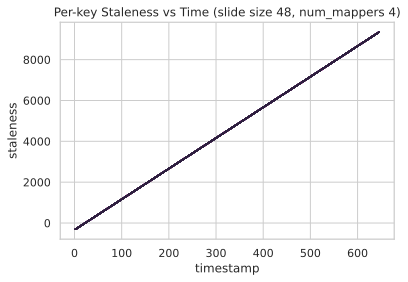

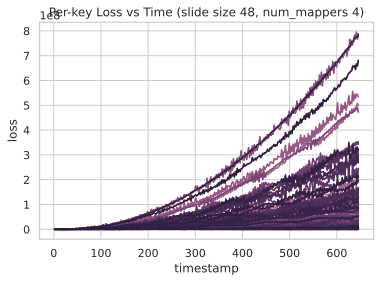

In [57]:
plot_loss_over_time(4, 48)

In [29]:
predictions_df

,timestamp,key,pred,oracle_pred,event_value,staleness,loss
0,112.259959,48,-1197.679858,-2977.404502,-2597.347342,1347,1.959069e+06
1,112.259959,9,-56.448870,-1417.451068,-741.194963,1347,4.688772e+05
2,112.259959,129,2399.438398,3388.739102,3895.080222,1347,2.236944e+06
3,112.259959,2,6304.781131,10095.160489,10427.137479,1347,1.699382e+07
4,112.259959,186,1719.122442,665.674106,1463.078585,1347,6.555846e+04
...,...,...,...,...,...,...,...
64395,102.237057,169,-1096.407824,419.298044,-484.341015,1197,3.746258e+05
64396,102.237057,193,-1896.818685,-2459.396575,-3327.572063,1197,2.047055e+06
64397,102.237057,8,-895.092207,-1604.189004,-1937.558623,1197,1.086736e+06
64398,102.237057,198,5272.182481,8939.301003,8587.895082,1197,1.099395e+07


In [30]:
(-11 - -111)**2  

10000

In [ ]:
slide_size_144 = mapper_4_slide_size[mapper_4_slide_size.slide_size == 144]
plt.scatter(x=list(range(len(slide_size_144))), y=slide_size_144.total_loss)

In [ ]:
result_df.total_predictions

In [ ]:
plt.figure(figsize=(10,3))
sns.barplot(data=result_df, hue="slide_size", y="num_missing_keys", x="cpu")
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,3))
sns.barplot(data=result_df, hue="slide_size", y="total_predictions", x="cpu")
plt.tight_layout()

In [ ]:
plan_file = "./offline/result/offline_1_slide/min_loss_plan_max_fits_1500.json"
vary_slide_plan = json.load(open(plan_file))

In [ ]:
plt.figure(figsize=(15,3))
vary_slide_df = pd.Series(vary_slide_plan).to_frame().reset_index().rename(columns={"index": "key", 0: "slide_size"})
sns.barplot(data=vary_slide_df, x="key", y="slide_size")
plt.tight_layout()

In [ ]:
from statsmodels.tsa.seasonal import STL

In [ ]:
from statsmodels.tsa.seasonal import STL
data = [1.0 for _ in range(678)]
%%time
stl = STL(data, period=168, robust=True)

In [ ]:
%%time
stl = STL(data, period=168, robust=True)